In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

## Jan Temp Quantiles
---
Load data and interpolate the design value field

In [2]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jan1.0p/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'tas'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = (interp_dict['iens'][:, master_idx])

Plot distribution.

Text(0.5, 1.0, 'KDE Distribution of tas Values')

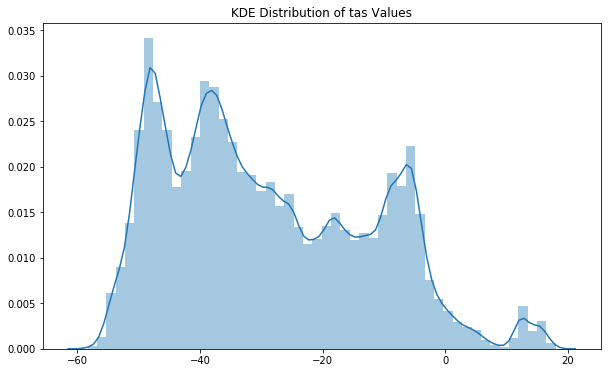

In [3]:
plt.figure(figsize=(10, 6))
sns.distplot(iens[0, ...])
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [4]:
u, s, vT = np.linalg.svd(iens, full_matrices=False)
del u

Calculate explained variance and plot

Text(0, 0.5, 'Explained Variance Ratio')

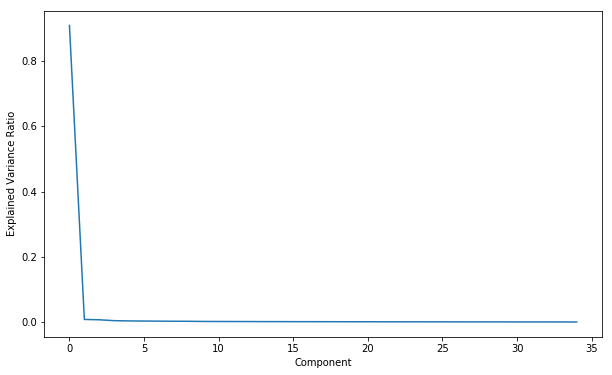

In [5]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

Load the quantile station data

In [6]:
df = pd.read_csv('/home/nannau/Desktop/climpyrical/data/jan_1st_percentile_1991_2016', index_col=None)
# df = df[df['completeness'] > 0.8]

In [7]:
ndf = match_coords(df, interp_dict, 'quantile')
print("There are ", ndf.shape, "real station observations to fit.")

There are  (1719, 5) real station observations to fit.


#### Create the pseudo observations and regress

In [8]:
obs_idx = generate_pseudo_obs(iens, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 270 pseudo observations


In [9]:
obs = iens[0, obs_idx]
eofs = vT[:4, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (4, 270) 
Matched Obs shape:  (270,)


Fit the EOFs tot he pseudo observations and predict their values

In [10]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: 0.9992129675054068 0.9992129675054068


slope 0.9992129675054064 r2_val 0.9996064062947009


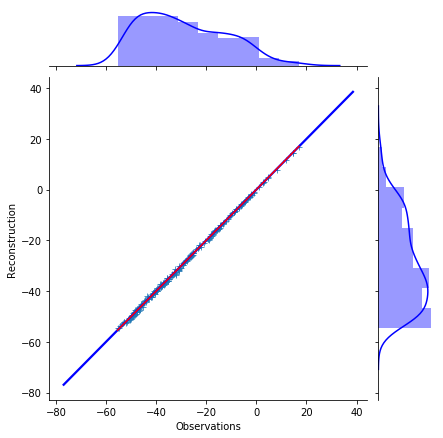

In [11]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [14]:
robs_idx = ndf['matched_idx']
robs = (ndf['quantile'].values)/10.0 # fix units
reofs = vT[:4, robs_idx]

Compare the distributions of the station observations and of the models

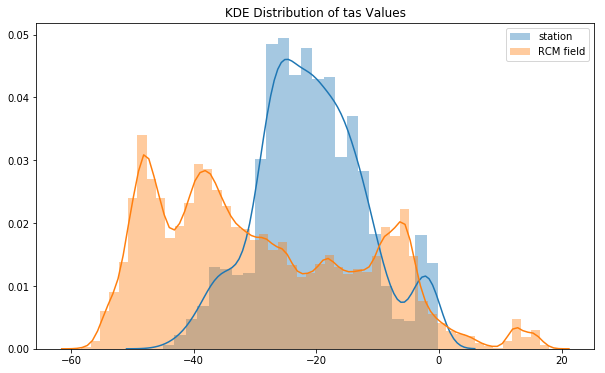

In [15]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, ...], label='RCM field')
plt.legend()

Fit the model and predict it

In [16]:
rmodel = fit_eof(reofs.T, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs.T)

Regressed model score: 0.4196706899455199 0.4196706899455199


slope 0.41967068994551937 r2_val 0.6478199517964228
Std deviation ratio of vectors: 1.8763562785874366


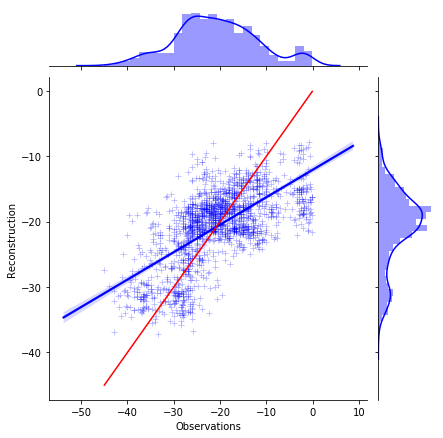

In [17]:

sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(robs.T, 
          robs.T,
          color='r',
            dashes=True)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors:", np.mean(np.std(iens, axis=1))/np.std(robs))